In [2]:
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.keras import Sequential, models
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Image path reading

In [3]:
def get_train_test_val(pathFolder, labels, pctTrain, pctTest, pctVal, typeImg='.png'):
    
    def __print(df, title):
        print(f'Number of records in {title}: {df.shape[0]}')
        print(f'Label distribution in {title}: {df.label.value_counts().to_dict()}')    
    
    if type(labels) != dict:
        print('The "labels" parameter must be of type dictionary')
        return

    if round(pctTrain + pctTest + pctVal) != 1:
        print('La suma de los porcentajes de train, test y validacion deben sumar 1')
        return
    
    pctVals = round(1-pctTrain, 2)
    pctTestFinal = round(pctTest/pctVals, 2)
    pctValFinal = round(1-pctTestFinal, 2)

    random.seed(1234)
    train_img = pd.DataFrame(columns=['pathImage', 'label'])
    test_img = pd.DataFrame(columns=['pathImage', 'label'])
    validation_img = pd.DataFrame(columns=['pathImage', 'label'])

    for label in labels.keys():
        
        class_num = labels[label]
        pathData = os.path.join(pathFolder, label)
        filesPng = [elem for elem in os.listdir(pathData) if elem.__contains__(typeImg)]
        filesPng = [os.path.join(pathData, elem) for elem in filesPng]
        filesTrain = random.sample(filesPng, round(len(filesPng) * pctTrain))
        filesVals = [elem for elem in filesPng if elem not in filesTrain]
        filesTest = random.sample(filesVals, round(len(filesVals)*pctTestFinal))
        filesVal = [elem for elem in filesVals if elem not in filesTest]
        df_train_label = pd.DataFrame(data=filesTrain, columns=['pathImage'])
        df_train_label['label'] = class_num
        df_test_label = pd.DataFrame(data=filesTest, columns=['pathImage'])
        df_test_label['label'] = class_num
        df_val_label = pd.DataFrame(data=filesVal, columns=['pathImage'])
        df_val_label['label'] = class_num
        
        train_img = train_img.append(df_train_label).reset_index(drop=True)
        test_img = test_img.append(df_test_label).reset_index(drop=True)
        validation_img = validation_img.append(df_val_label).reset_index(drop=True)

    dict_dfs = {'train':train_img, 'test':test_img, 'validation':validation_img}
    for key in dict_dfs.keys():
        __print(dict_dfs[key], key)
        
    train_img = train_img.sample(len(train_img)).reset_index(drop=True)
    test_img = test_img.sample(len(test_img)).reset_index(drop=True)
    validation_img = validation_img.sample(len(validation_img)).reset_index(drop=True)
    
    return train_img, test_img, validation_img


In [4]:
pathImages = './Images/'
labels = {'without_mask':0, 'with_mask':1}

In [5]:
train_img, test_img, validation_img = get_train_test_val(pathImages, labels, 0.7, 0.2, 0.1)
display(train_img.head(2))
display(test_img.head(2))
display(validation_img.head(2))

Number of records in train: 4192
Label distribution in train: {1: 2096, 0: 2096}
Number of records in test: 1204
Label distribution in test: {1: 602, 0: 602}
Number of records in validation: 592
Label distribution in validation: {1: 296, 0: 296}


,pathImage,label
0,./Images/without_mask\2525.png,0
1,./Images/without_mask\1926.png,0


,pathImage,label
0,./Images/without_mask\2224.png,0
1,./Images/with_mask\1938.png,1


,pathImage,label
0,./Images/with_mask\1660.png,1
1,./Images/without_mask\2664.png,0


In [6]:
def show_images(df, showRealImage, nImage=3, labels=labels):
    
    def __from_path_to_img(file):
        img = image.load_img(file, target_size=(28, 28, 1))
        img = image.img_to_array(img)
        img = img/255
        return img

    random.seed(22)
    imagesShows = []
    for key in labels.keys():
        listImage = df[df['label'] == labels[key]]['pathImage'].tolist()
        imagesShows.extend(random.sample(listImage, nImage))
        
    plt.figure(figsize=(8, 4))       
        
    for i, file in enumerate(imagesShows):
        if showRealImage == True:
            img = mpimg.imread(file)
        else:
            img = __from_path_to_img(file)
            img = cv2.resize(img, (100, 100))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.subplot(len(list(labels.keys())), nImage, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap='gray')

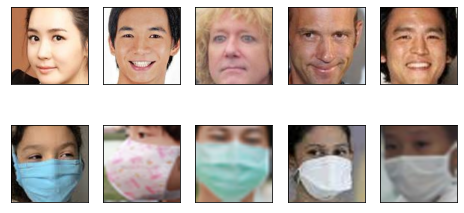

In [7]:
# View images
show_images(train_img, True, 5)

### Split train, test and validation from image to array

In [8]:
def from_img_to_array(df, size_img=100):
    
    img_array = []
    label_array = []
    
    for i in tqdm(range(len(df))):
        
        img = cv2.imread(df['pathImage'][i])
        img = cv2.resize(img, (size_img, size_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(size_img, size_img, 1)
        img = np.array(img)
        img = img.astype('float32')/255
        img_array.append(img)
        label_array.append(df['label'][i])
        
    img_array = np.array(img_array)
    label_array = np.array(list(map(int, label_array)), np.float32)    
    
    return img_array, label_array


def plt_results_model(modelo, size=(18, 5)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
    ax1.plot(modelo.history['accuracy'], label='train', marker='o', linestyle=':')
    ax1.plot(modelo.history['val_accuracy'], label='validation', marker='x', linestyle=':')

    ax2.plot(modelo.history['loss'], label='train', marker='o', linestyle=':')
    ax2.plot(modelo.history['val_loss'], label='validation', marker='x', linestyle=':')

    ax1.set_title('Accuracy per epoch')
    ax2.set_title('Loss per epoch')
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_ylabel('Accuracy')
    ax2.set_ylabel('Loss')
    ax1.legend()
    ax2.legend()
    plt.show()


In [9]:
X_train_array, y_train_array = from_img_to_array(train_img)
X_test_array, y_test_array = from_img_to_array(test_img)
X_validation_array, y_validation_array = from_img_to_array(validation_img)

100%|██████████| 592/592 [00:05<00:00, 109.55it/s]


### Development of models

In [10]:
modeloCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [11]:
tensorboardCNN = TensorBoard(log_dir='./logs/cnn')
history_modeloCNN = modeloCNN.fit(x=X_train_array, y=y_train_array,  
                                  epochs=10,
                                  validation_data=(X_test_array, y_test_array), 
                                  callbacks=[tensorboardCNN])

Epoch 1/10
131/131 [==============================] - 35s 262ms/step - loss: 0.5484 - accuracy: 0.6888 - val_loss: 0.1779 - val_accuracy: 0.9369
Epoch 2/10
131/131 [==============================] - 32s 242ms/step - loss: 0.1941 - accuracy: 0.9257 - val_loss: 0.1815 - val_accuracy: 0.9360
Epoch 3/10
131/131 [==============================] - 32s 243ms/step - loss: 0.1731 - accuracy: 0.9347 - val_loss: 0.1058 - val_accuracy: 0.9659
Epoch 4/10
131/131 [==============================] - 32s 241ms/step - loss: 0.1159 - accuracy: 0.9512 - val_loss: 0.0878 - val_accuracy: 0.9734
Epoch 5/10
131/131 [==============================] - 32s 243ms/step - loss: 0.0987 - accuracy: 0.9559 - val_loss: 0.0922 - val_accuracy: 0.9734
Epoch 6/10
131/131 [==============================] - 32s 242ms/step - loss: 0.0788 - accuracy: 0.9696 - val_loss: 0.0863 - val_accuracy: 0.9734
Epoch 7/10
131/131 [==============================] - 32s 241ms/step - loss: 0.0709 - accuracy: 0.9745 - val_loss: 0.0902 - val_ac

In [36]:
test_loss, test_acc = modeloCNN.evaluate(X_test_array, y_test_array, verbose=0)
print(f'Model loss: {round(test_loss, 4)} \nModel accuracy: {round(test_acc*100, 2)}%')

Model loss: 0.0772 
Model accuracy: 98.01%


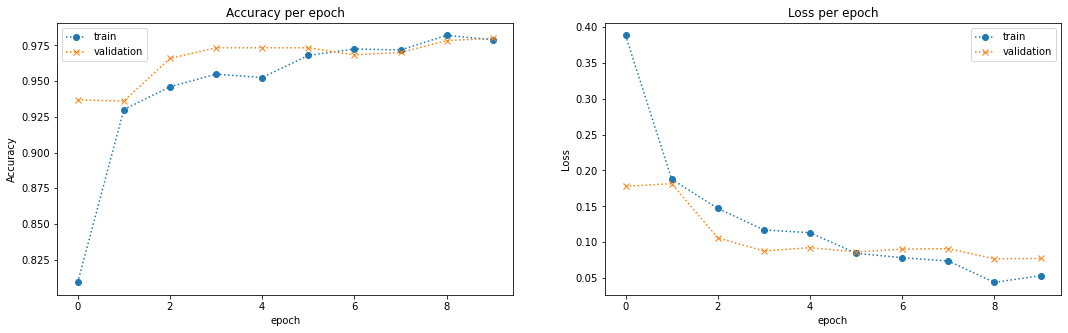

In [13]:
plt_results_model(history_modeloCNN)

$\;$

In [14]:
modeloCNN_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN_1.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [15]:
tensorboardCNN_1 = TensorBoard(log_dir='./logs/cnn_1')
history_modeloCNN_1 = modeloCNN_1.fit(x=X_train_array, y=y_train_array,  
                                      epochs=10,
                                      validation_data=(X_test_array, y_test_array), 
                                      callbacks=[tensorboardCNN])

Epoch 1/10
131/131 [==============================] - 28s 208ms/step - loss: 0.6364 - accuracy: 0.5997 - val_loss: 0.4323 - val_accuracy: 0.9061
Epoch 2/10
131/131 [==============================] - 24s 186ms/step - loss: 0.4303 - accuracy: 0.8936 - val_loss: 0.3772 - val_accuracy: 0.9211
Epoch 3/10
131/131 [==============================] - 24s 184ms/step - loss: 0.3721 - accuracy: 0.9320 - val_loss: 0.3359 - val_accuracy: 0.9394
Epoch 4/10
131/131 [==============================] - 24s 183ms/step - loss: 0.3424 - accuracy: 0.9410 - val_loss: 0.3098 - val_accuracy: 0.9601
Epoch 5/10
131/131 [==============================] - 24s 183ms/step - loss: 0.2939 - accuracy: 0.9572 - val_loss: 0.1464 - val_accuracy: 0.9527
Epoch 6/10
131/131 [==============================] - 24s 185ms/step - loss: 0.1241 - accuracy: 0.9581 - val_loss: 0.1178 - val_accuracy: 0.9626
Epoch 7/10
131/131 [==============================] - 24s 184ms/step - loss: 0.0950 - accuracy: 0.9673 - val_loss: 0.1128 - val_ac

In [35]:
test_loss_1, test_acc_1 = modeloCNN_1.evaluate(X_test_array, y_test_array, verbose=0)
print(f'Model loss: {round(test_loss_1, 4)} \nModel accuracy: {round(test_acc_1*100, 2)}%')

Model loss: 0.1191 
Model accuracy: 95.85%


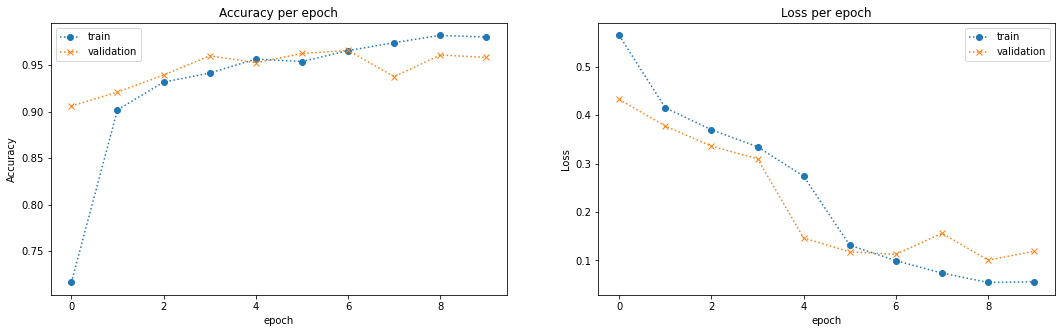

In [17]:
plt_results_model(history_modeloCNN_1)

$\;$

In [18]:
modeloCNN_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Dropout(0.5), # omission of neurons acting as feature detectors
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

modeloCNN_2.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy'])

In [19]:
tensorboardCNN_2 = TensorBoard(log_dir='./logs/cnn_2')
history_modeloCNN_2 = modeloCNN_2.fit(x=X_train_array, y=y_train_array,  
                                      epochs=10,
                                      validation_data=(X_test_array, y_test_array), 
                                      callbacks=[tensorboardCNN_2])

Epoch 1/10
131/131 [==============================] - 36s 268ms/step - loss: 0.4917 - accuracy: 0.7426 - val_loss: 0.1699 - val_accuracy: 0.9385
Epoch 2/10
131/131 [==============================] - 32s 244ms/step - loss: 0.1804 - accuracy: 0.9334 - val_loss: 0.1592 - val_accuracy: 0.9419
Epoch 3/10
131/131 [==============================] - 32s 245ms/step - loss: 0.1549 - accuracy: 0.9443 - val_loss: 0.1054 - val_accuracy: 0.9651
Epoch 4/10
131/131 [==============================] - 32s 244ms/step - loss: 0.1232 - accuracy: 0.9525 - val_loss: 0.1049 - val_accuracy: 0.9651
Epoch 5/10
131/131 [==============================] - 31s 240ms/step - loss: 0.1229 - accuracy: 0.9520 - val_loss: 0.0876 - val_accuracy: 0.9643
Epoch 6/10
131/131 [==============================] - 32s 242ms/step - loss: 0.0949 - accuracy: 0.9636 - val_loss: 0.0925 - val_accuracy: 0.9718
Epoch 7/10
131/131 [==============================] - 32s 243ms/step - loss: 0.0913 - accuracy: 0.9657 - val_loss: 0.1023 - val_ac

In [34]:
test_loss_2, test_acc_2 = modeloCNN_2.evaluate(X_test_array, y_test_array, verbose=0)
print(f'Model loss: {round(test_loss_2, 4)} \nModel accuracy: {round(test_acc_2*100, 2)}%')

Model loss: 0.0781 
Model accuracy: 96.93%


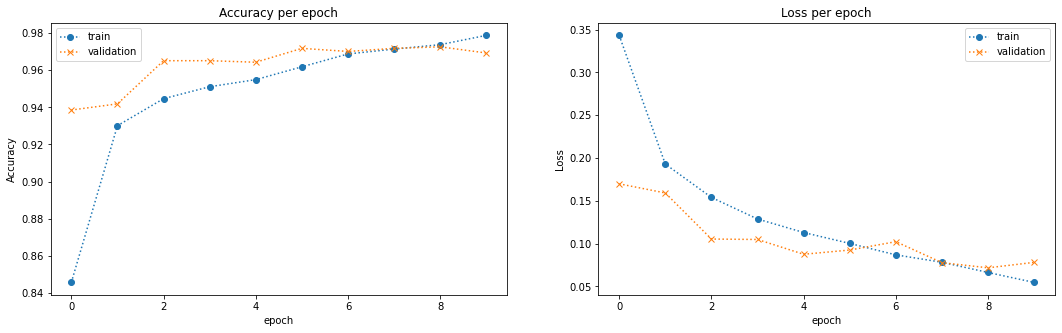

In [21]:
plt_results_model(history_modeloCNN_2)

$\;$

In [22]:
# %load_ext tensorboard

In [23]:
# %tensorboard --logdir logs/

### Development of a new model with new images generated with the ImageDataGenerator function

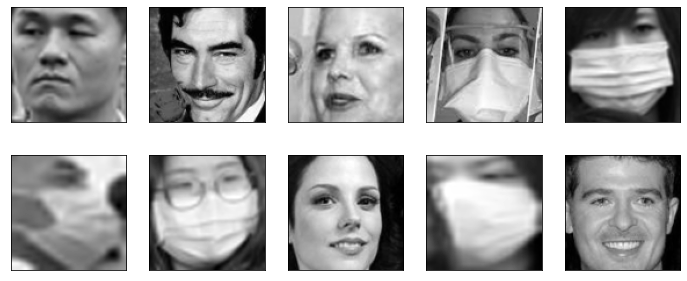

In [24]:
# Currently the image used in traning model are as follows
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train_array[i].reshape(100, 100), cmap='gray')

In [25]:
datagen = ImageDataGenerator(
    rotation_range = 50, # random rotation of images, we indicate maximum angle of rotation 
    width_shift_range = 0.2, # scrolls the image to the left or right
    height_shift_range = 0.2, # scrolls the image up or down
    shear_range = 15, # randomly applies shear transformations
    horizontal_flip = True, # randomly rotates half of the images horizontally
    vertical_flip = True # randomly rotates half of the images vertically
)

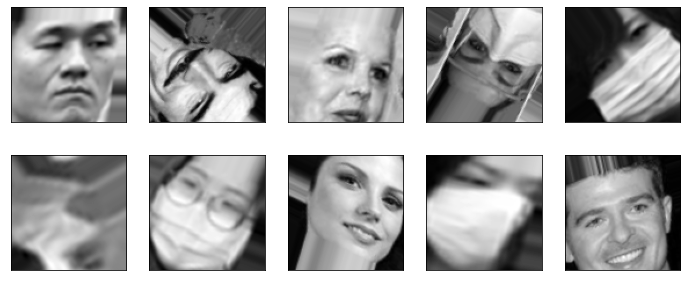

In [26]:
# The new images generated would look like this
datagen.fit(X_train_array)

plt.figure(figsize=(12, 5))
for imagen, etiqueta in datagen.flow(X_train_array, y_train_array, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imagen[i].reshape(100, 100), cmap='gray')
    break 

In [27]:
modeloCNN_AD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [28]:
modeloCNN_AD.compile(optimizer='adam', 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

In [29]:
data_gen_train = datagen.flow(X_train_array, y_train_array, batch_size=32)

In [30]:
tensorboardCNN_AD = TensorBoard(log_dir='./logs/cnn_AD')
history_modeloCNN_AD = modeloCNN_AD.fit(x=data_gen_train, 
                                        epochs=10,
                                        batch_size=32,
                                        validation_data=(X_test_array, y_test_array), 
                                        steps_per_epoch=int(np.ceil(len(X_train_array) / float(32))),
                                        validation_steps=int(np.ceil(len(X_test_array) / float(32))),
                                        callbacks=[tensorboardCNN_AD])

Epoch 1/10
131/131 [==============================] - 34s 254ms/step - loss: 0.6959 - accuracy: 0.5177 - val_loss: 0.6390 - val_accuracy: 0.6944
Epoch 2/10
131/131 [==============================] - 31s 239ms/step - loss: 0.6733 - accuracy: 0.6045 - val_loss: 0.6047 - val_accuracy: 0.6412oss: 0.6770 - accurac - ETA: 14s - l - E
Epoch 3/10
131/131 [==============================] - 31s 235ms/step - loss: 0.6247 - accuracy: 0.6616 - val_loss: 0.4831 - val_accuracy: 0.802399 - accuracy: 0.6 - ETA: 22s - loss: 0.65 - ETA: 18s - loss - ETA: 12s - loss: 0.6384 - accuracy: 0. - ETA: 11s - loss: 0.63 - ETA: 8s - loss: 0.6338 - accura - ETA: 7s - loss: 0
Epoch 4/10
131/131 [==============================] - 31s 236ms/step - loss: 0.5535 - accuracy: 0.7225 - val_loss: 0.4137 - val_accuracy: 0.8339A: 24s - loss: 0.5751 - accuracy: 0. - ETA: 23s - loss: 0.5699 - accuracy: 0.72 - ETA: 23s - loss: 0.5677 -  - ETA: 19s - loss: 0.5605 - accuracy:  - ETA: 18s - loss: 0.5587 - ETA: 13s - loss: 0.5581 - 

In [33]:
test_loss_ad, test_acc_ad = modeloCNN_AD.evaluate(X_test_array, y_test_array, verbose=0)
print(f'Model loss: {round(test_loss_ad, 4)} \nModel accuracy: {round(test_acc_ad*100, 2)}%')

Model loss: 0.2226 
Model accuracy: 92.03%


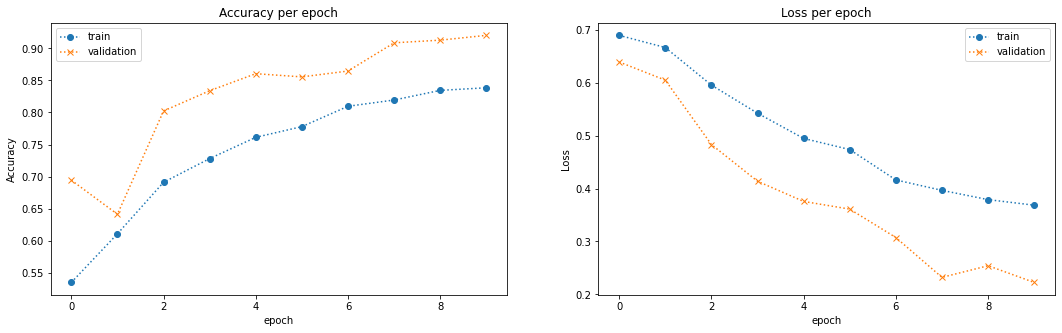

In [32]:
plt_results_model(history_modeloCNN_AD)

$\;$

### Prediction models

In [43]:
def make_prediction(modelo, X_array, y_true, pltMisclassified, size=(12, 10)):
    
    def __plt_confusion_matrix(y_true, y_pred, size=size):
        
        cf_matrix = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=size)
        sns.heatmap(cf_matrix, annot=True, fmt='g')
        plt.title('Confusion matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()
        
    
    def __plt_img_bad_classifier(y_true, y_pred):
        
        df_pred = pd.DataFrame(columns=['y_true', 'y_pred'])
        df_pred['y_true'] = y_true.tolist()
        df_pred['y_true'] = df_pred['y_true'].astype(int)
        df_pred['y_pred'] = y_pred
        df_pred['differences'] = np.where(df_pred['y_true'] != df_pred['y_pred'], 1, 0)

        images_bad_classifier = df_pred[df_pred['differences'] == 1].index.tolist()
        print(f'Number of misclassified images: {len(images_bad_classifier)}')
        
        plt.figure(figsize=(12, 5))
        for i, i_b in enumerate(random.sample(images_bad_classifier, 10)):
            plt.subplot(2, 5, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_validation_array[i_b].reshape(100, 100), cmap='gray')
            
        plt.show()
        
    pred_prob = modelo.predict(X_array)
    pred_class = [1 * (x[0] >= 0.5) for x in pred_prob]

    # Accuracy
    acc = accuracy_score(y_true, pred_class)
    print(f'Prediction accuracy: {round(acc*100, 2)}%')
    
    # Confusion matrix
    __plt_confusion_matrix(y_true, pred_class)
    
    # Show misclassified images
    if pltMisclassified == True:
        __plt_img_bad_classifier(y_true, pred_class)

In [45]:
models = {'modeloCNN':modeloCNN, 
          'modeloCNN_1':modeloCNN_1, 
          'modeloCNN_2':modeloCNN_2, 
          'modeloCNN_AD':modeloCNN_AD}

In [46]:
df_comparative = pd.DataFrame(columns=['Modelo', 'loss', 'accuracy'])

for key in models.keys():
    modelo = models[key]
    loss, acc = modelo.evaluate(X_test_array, y_test_array, verbose=0)
    df_comparative.loc[len(df_comparative)] = [key, loss, acc]
    
df_comparative

,Modelo,loss,accuracy
0,modeloCNN,0.077204,0.980066
1,modeloCNN_1,0.119083,0.958472
2,modeloCNN_2,0.078134,0.969269
3,modeloCNN_AD,0.222577,0.920266


Modelo: modeloCNN
Prediction accuracy: 96.79%


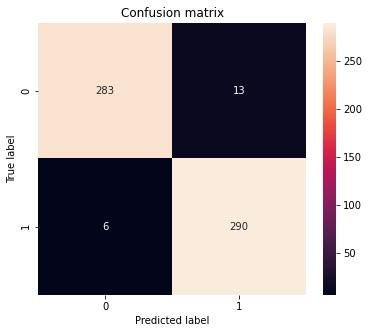

Number of misclassified images: 19


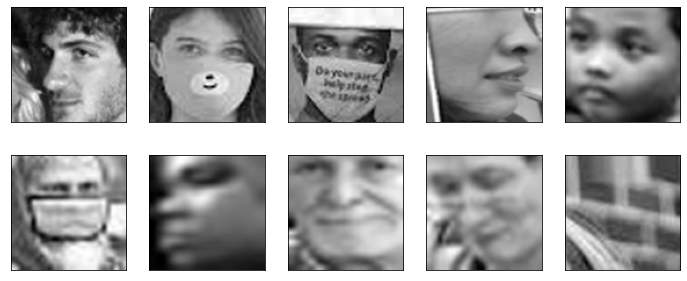

Modelo: modeloCNN_1
Prediction accuracy: 94.93%


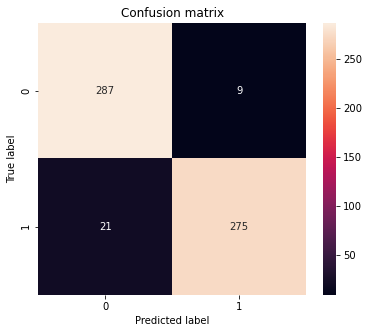

Number of misclassified images: 30


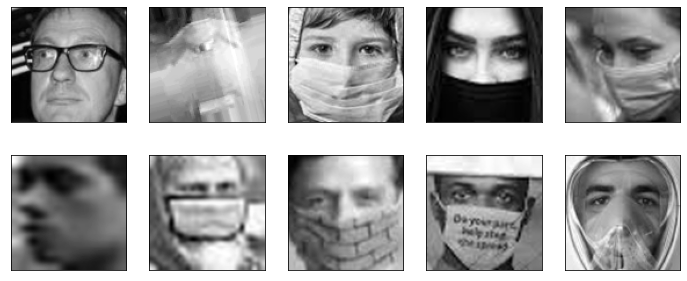

Modelo: modeloCNN_2
Prediction accuracy: 95.95%


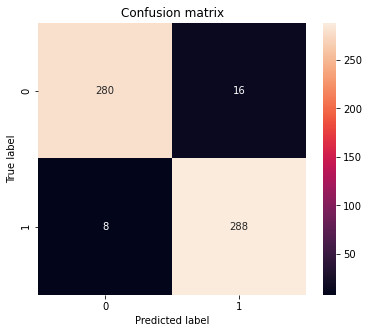

Number of misclassified images: 24


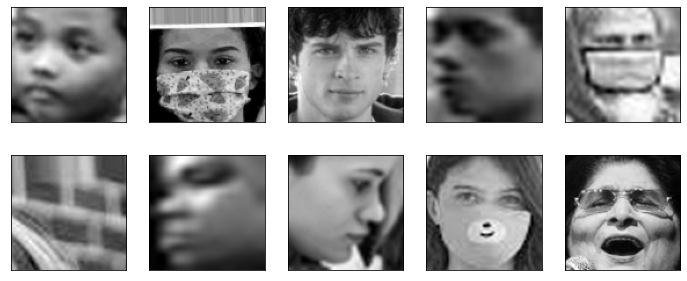

Modelo: modeloCNN_AD
Prediction accuracy: 89.86%


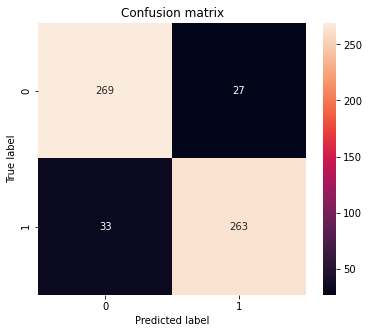

Number of misclassified images: 60


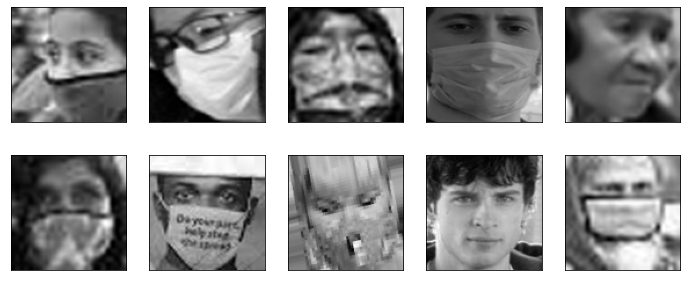

In [44]:
for key in models.keys():
    print(f'Modelo: {key}')
    make_prediction(models[key], X_validation_array, y_validation_array, True, (6, 5))

### Export of the modelo

After all the models developed, the "modelCNN" model has the best results. 

In [51]:
modeloCNN.save('facemask_detection.model')

INFO:tensorflow:Assets written to: facemask_detection.model\assets
